In [1]:
%config InlineBackend.figure_format = 'svg'
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import autograd.numpy as np
from autograd import grad
from tqdm import tqdm_notebook as tqdm
import pandas as pd

from utils import rbf

DATA_DIR = "../data/gplvm/"
IMG_FOLDER = "../images/gplvm/"

In [2]:
def loglik(K, Y):
    
    D, N = Y.shape
    K_inv = np.linalg.inv(K)

    return -D*N/2*np.log(2*np.pi) - D/2*np.linalg.slogdet(K)[1] - 0.5*np.trace(np.dot(np.dot(K_inv, Y), Y.T))

In [3]:
def fit(Y, latent_dim, alpha, beta, gamma, learn_rate=1e-6, num_iter=10000, verbose=True, log_every=50):
    
    # Initial guess for X
    pca = PCA(n_components=latent_dim)
    X = pca.fit_transform(Y)

    K = rbf(X, alpha, gamma, beta)
    L = loglik(K, Y)
    
    loglik_lambda = lambda X_, alpha_, beta_, gamma_: loglik(rbf(X_, alpha_, gamma_, beta_), Y)
    
    theta = [X, alpha, beta, gamma]
    
    dloglik_dtheta = [grad(loglik_lambda, i) for i in range(len(theta))]

    for i in tqdm(range(num_iter)):
        
        grads = [loglik_partial(*theta) for loglik_partial in dloglik_dtheta]
        theta[0] = theta[0] + learn_rate * grads[0] #[theta[j] + learn_rate * gradient for j, gradient in enumerate(grads)]
        theta[1] = theta[1] + learn_rate * grads[1]
        theta[2] = theta[2] + 1e-15 * grads[2]
        theta[3] = theta[3] + 1e-7 * grads[3]
        
        if verbose and i % log_every == 0: 
            print("Log-likelihood (iteration {}): {:.3f}".format(i + 1, loglik_lambda(*theta)))
    
    if verbose:
        print("Final log-likelihood: {:.3f}".format(loglik_lambda(*theta)))
    return tuple(theta)

In [4]:
latent_dim = 2

# oil dataset
Y = pd.read_csv(DATA_DIR + '/train_data.txt', header=None, sep='\s+').values[:500, :]
labels = (pd.read_csv(DATA_DIR + '/labels.txt', header=None, sep='\s+').values[:500, :]).astype(np.int)

alpha, beta, gamma = 1., 1e-4, 1.
X, alpha, beta, gamma = fit(Y, latent_dim, alpha, beta, gamma, num_iter=150, learn_rate=1e-5, verbose=True, log_every=50)

Log-likelihood (iteration 1): 439569.563
Log-likelihood (iteration 51): 937784.287
Log-likelihood (iteration 101): 909782.524

Final log-likelihood: 927536.905


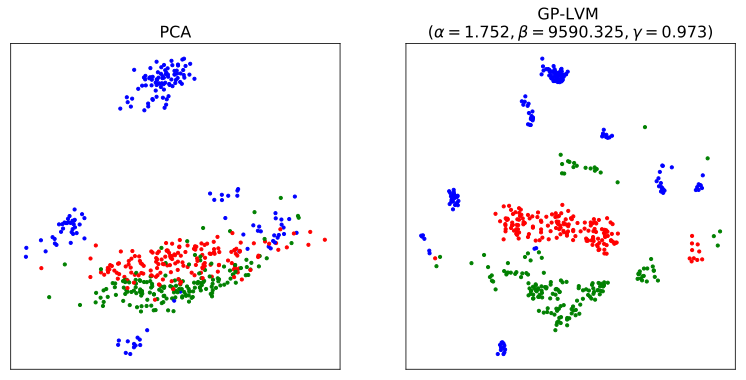

In [5]:
plt.figure(figsize = (13, 6))
plt.subplot(121)
pca = PCA(n_components=latent_dim)
X_pca = pca.fit_transform(Y)
X_pca = X_pca
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10, c=np.array(['r', 'g', 'b'])[np.where(labels)[1]])
plt.title('PCA', fontsize=16)
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.scatter(X[:, 0], X[:, 1], s=10, c=np.array(['r', 'g', 'b'])[np.where(labels)[1]])
plt.title('GP-LVM \n($\\alpha = {:.3f}, \\beta = {:.3f}, \\gamma = {:.3f}$)'.format(np.sqrt(alpha), 
                                                                      1./beta, 
                                                                      1./np.sqrt(gamma)), fontsize=16)
plt.xticks([])
plt.yticks([])
plt.savefig(IMG_FOLDER +'/clustered.png')
plt.show()